- In this notebook, I show the performance of RNet and generated the input data of ONet  
- As I mentioned in the first notebook (step 1), I will not show the repetitive parts. 

## The RNet Box
- Given the image, and the bounding boxes generated from the **pnet box**, it generates the image boxes with the size of 24

- Then, it puts these image boxes into RNet to get prediction boxes, converts the boxes into squares and calibrates them according to the offset values.

- After that, it chooses the boxes that might have face (larger than **MIN_FACE_SIZE**) based on the **THRESHOLDS** and deletes the repetitive boxes based on the **NMS_THRESHOLDS**  
- Finally, it returns the bounding box information to show the images.

In [4]:
THRESHOLDS = [0.85,0.03]
NMS_THRESHOLDS = [0.5,0.9]
MIN_FACE_SIZE = 15.0

def rnet_boxes(img, rnet, bounding_boxes, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS, show_boxes=True):
    rnet.eval()
    img_boxes = get_image_boxes(bounding_boxes, img, size=24)
    try:
        img_boxes = torch.FloatTensor(img_boxes)
        img_boxes=img_boxes.cuda()
        output = rnet(img_boxes)
        probs = output[0].data.cpu().numpy()  # shape [n_boxes, 1]
        offsets = output[1].data.cpu().numpy()  # shape [n_boxes, 4]

        keep = np.where(probs[:, 0] > thresholds[1])[0]
        bounding_boxes = bounding_boxes[keep]
        bounding_boxes[:, 4] = probs[keep, 0].reshape((-1,))
        offsets = offsets[keep]

        keep = nms(bounding_boxes, nms_thresholds[1])
        bounding_boxes = bounding_boxes[keep]
        bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
        bounding_boxes = convert_to_square(bounding_boxes)
        bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
        if show_boxes: show_bboxes(img, bounding_boxes, []).show()
        return bounding_boxes
    except:
        return None

## Show the Boxes

#### Set the parameters

In [10]:
train_txt_path='../input/wider-data/WIDER/wider_face_train_bbx_gt.txt'
eval_txt_path='../input/wider-data/WIDER/wider_face_val_bbx_gt.txt'
train_img_path='../input/wider-data/WIDER/WIDER_train'
eval_img_path='../input/wider-data/WIDER/WIDER_val'
pnet_weight_path='../input/for-rnet/pnet_10000_40.pkl'
rnet_weight_path='../input/rnet-weights/rnet_12798_60_2_pretrained.pkl'
train_num=None
eval_num=None
class_data_augment = 3 
pnet=P_Net().cuda()
pnet.load_state_dict(torch.load(pnet_weight_path))
pnet.eval()
rnet=R_Net().cuda()
rnet.load_state_dict(torch.load(rnet_weight_path))
rnet.eval()

R_Net(
  (pre_layer): Sequential(
    (0): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(48, 64, kernel_size=(2, 2), stride=(1, 1))
    (7): PReLU(num_parameters=1)
  )
  (conv4): Linear(in_features=256, out_features=128, bias=True)
  (prelu4): PReLU(num_parameters=1)
  (conv5_1): Linear(in_features=128, out_features=1, bias=True)
  (conv5_2): Linear(in_features=128, out_features=4, bias=True)
  (conv5_3): Linear(in_features=128, out_features=10, bias=True)
)

#### Open the image and show the PNet performance

185


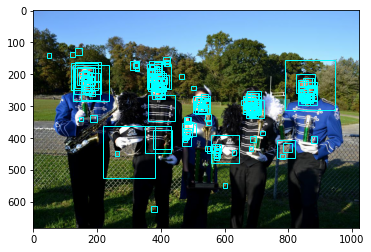

In [12]:
img = Image.open('../input/wider-data/WIDER/WIDER_train/0--Parade/0_Parade_marchingband_1_95.jpg')
bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
print(len(bounding_boxes))
show_boxes(img, bounding_boxes)

#### Show the RNet performance

24


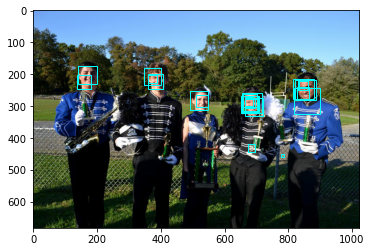

In [13]:
bounding_boxes=rnet_boxes(img, rnet, bounding_boxes, show_boxes=False)
print(len(bounding_boxes))
show_boxes(img, bounding_boxes)

#### Show more sample images from the training set

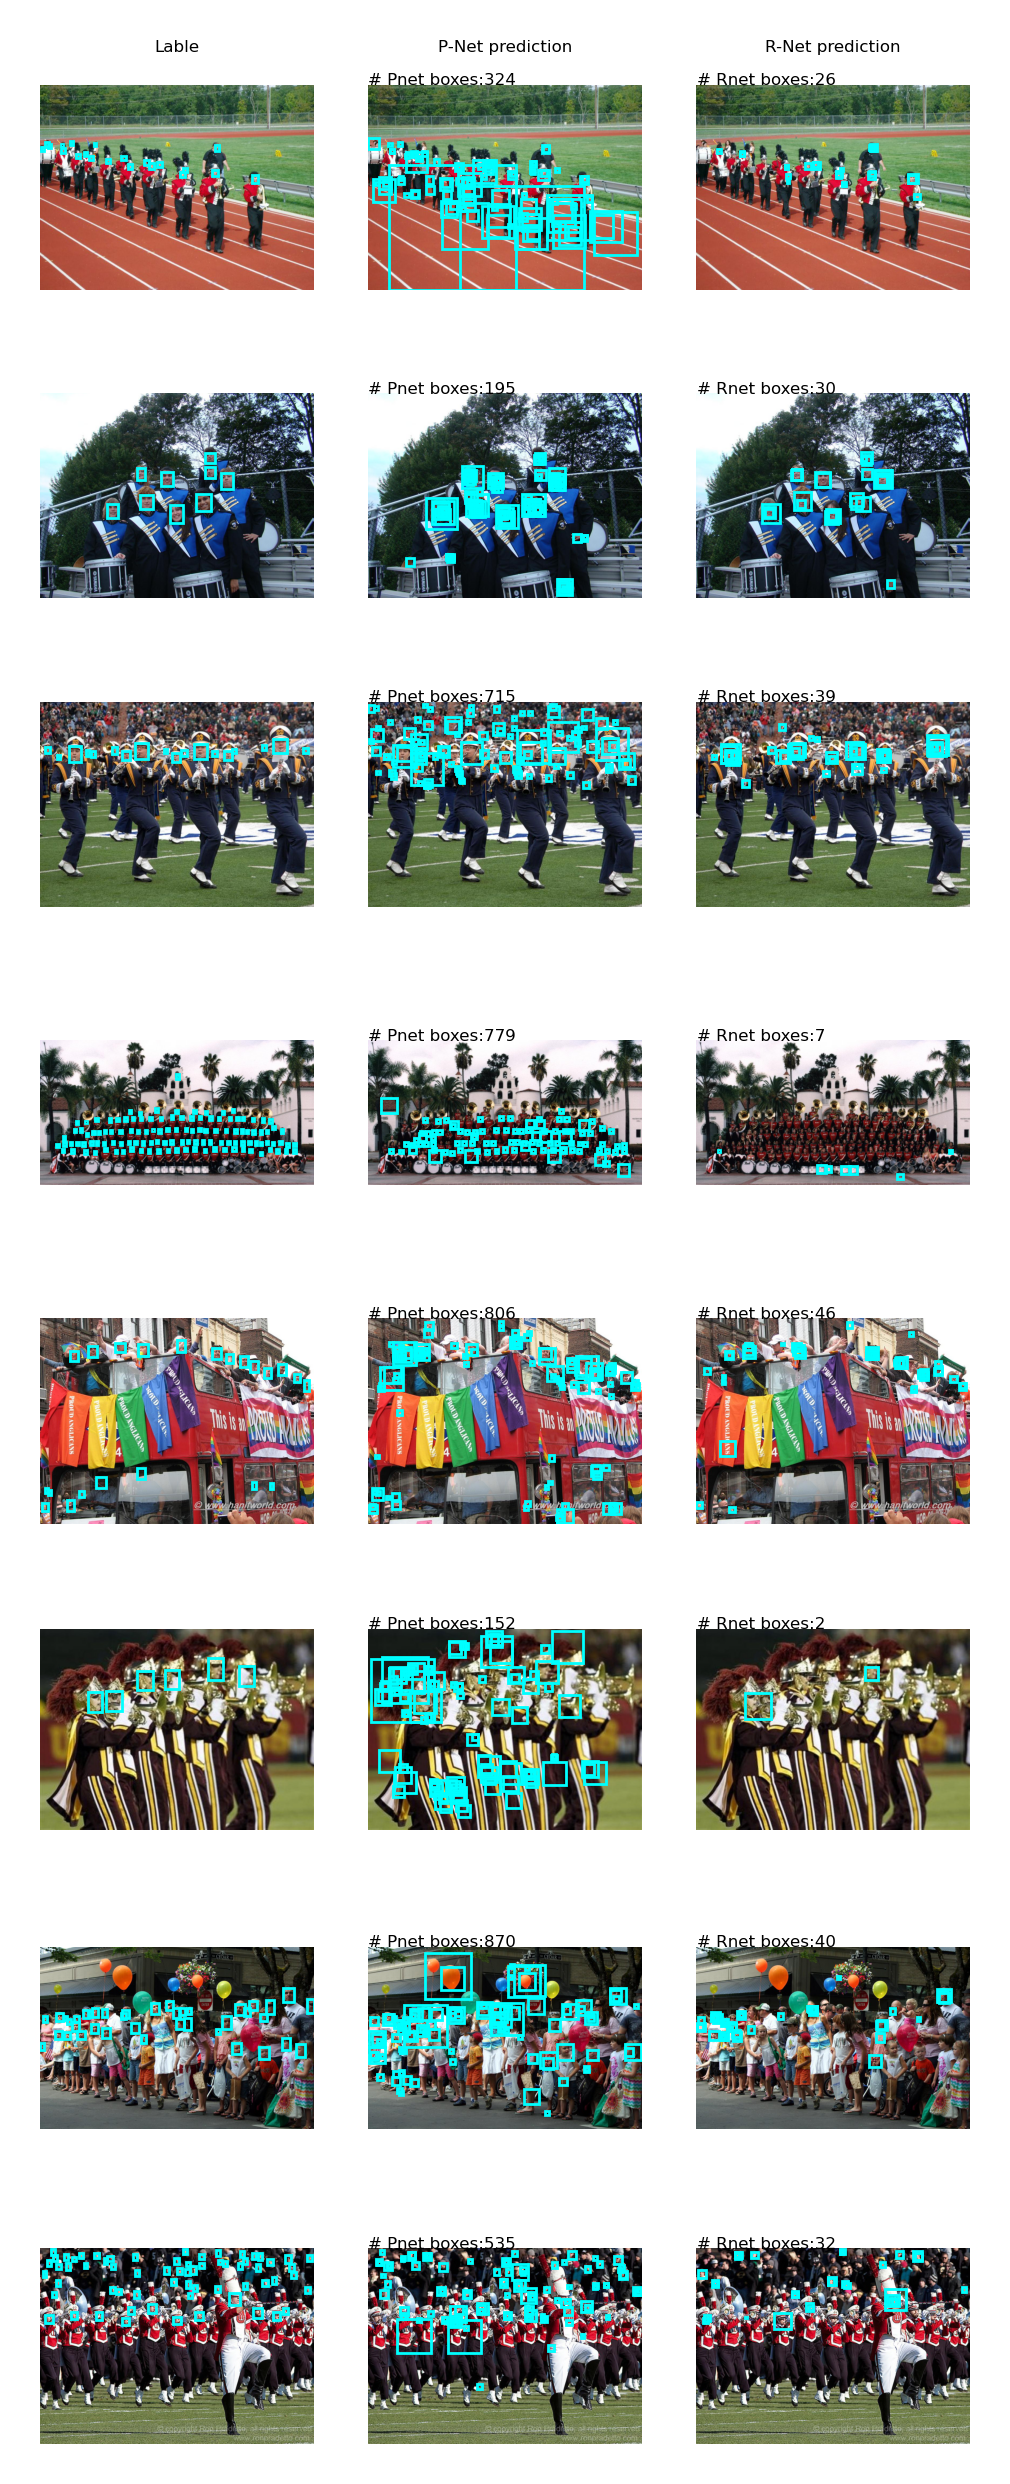

In [14]:
# get 8 fixed images
data_for_demo = create_pnet_data_txt_parser(train_txt_path,train_img_path ,num_data=40)
shuffle(data_for_demo)
data_for_demo=data_for_demo[:8]



# demo and plot
fig, ax = plt.subplots(8,3,dpi = 400, figsize=(3,8))

for i in range(len(data_for_demo)):
    img_pth, gts = data_for_demo[i]
    img = Image.open(img_pth)
    p_bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    r_bounding_boxes=rnet_boxes(img, rnet, p_bounding_boxes, show_boxes=False)
    ax[i,0].imshow(img)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3], fill=False, edgecolor = 'cyan',linewidth=0.5));
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# Pnet boxes:'+str(len(p_bounding_boxes)),fontsize=3)
    for b in p_bounding_boxes[:100]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
    
    ax[i,2].imshow(img)
    ax[i,2].text(0, 0, '# Rnet boxes:'+str(len(r_bounding_boxes)),fontsize=3)
    for b in r_bounding_boxes:
        ax[i,2].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   

for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Lable",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
ax[0][2].set_title("R-Net prediction",fontsize=3)
fig.show()
fig.savefig('demo_train.png')

#### Show more sample images from the eval set

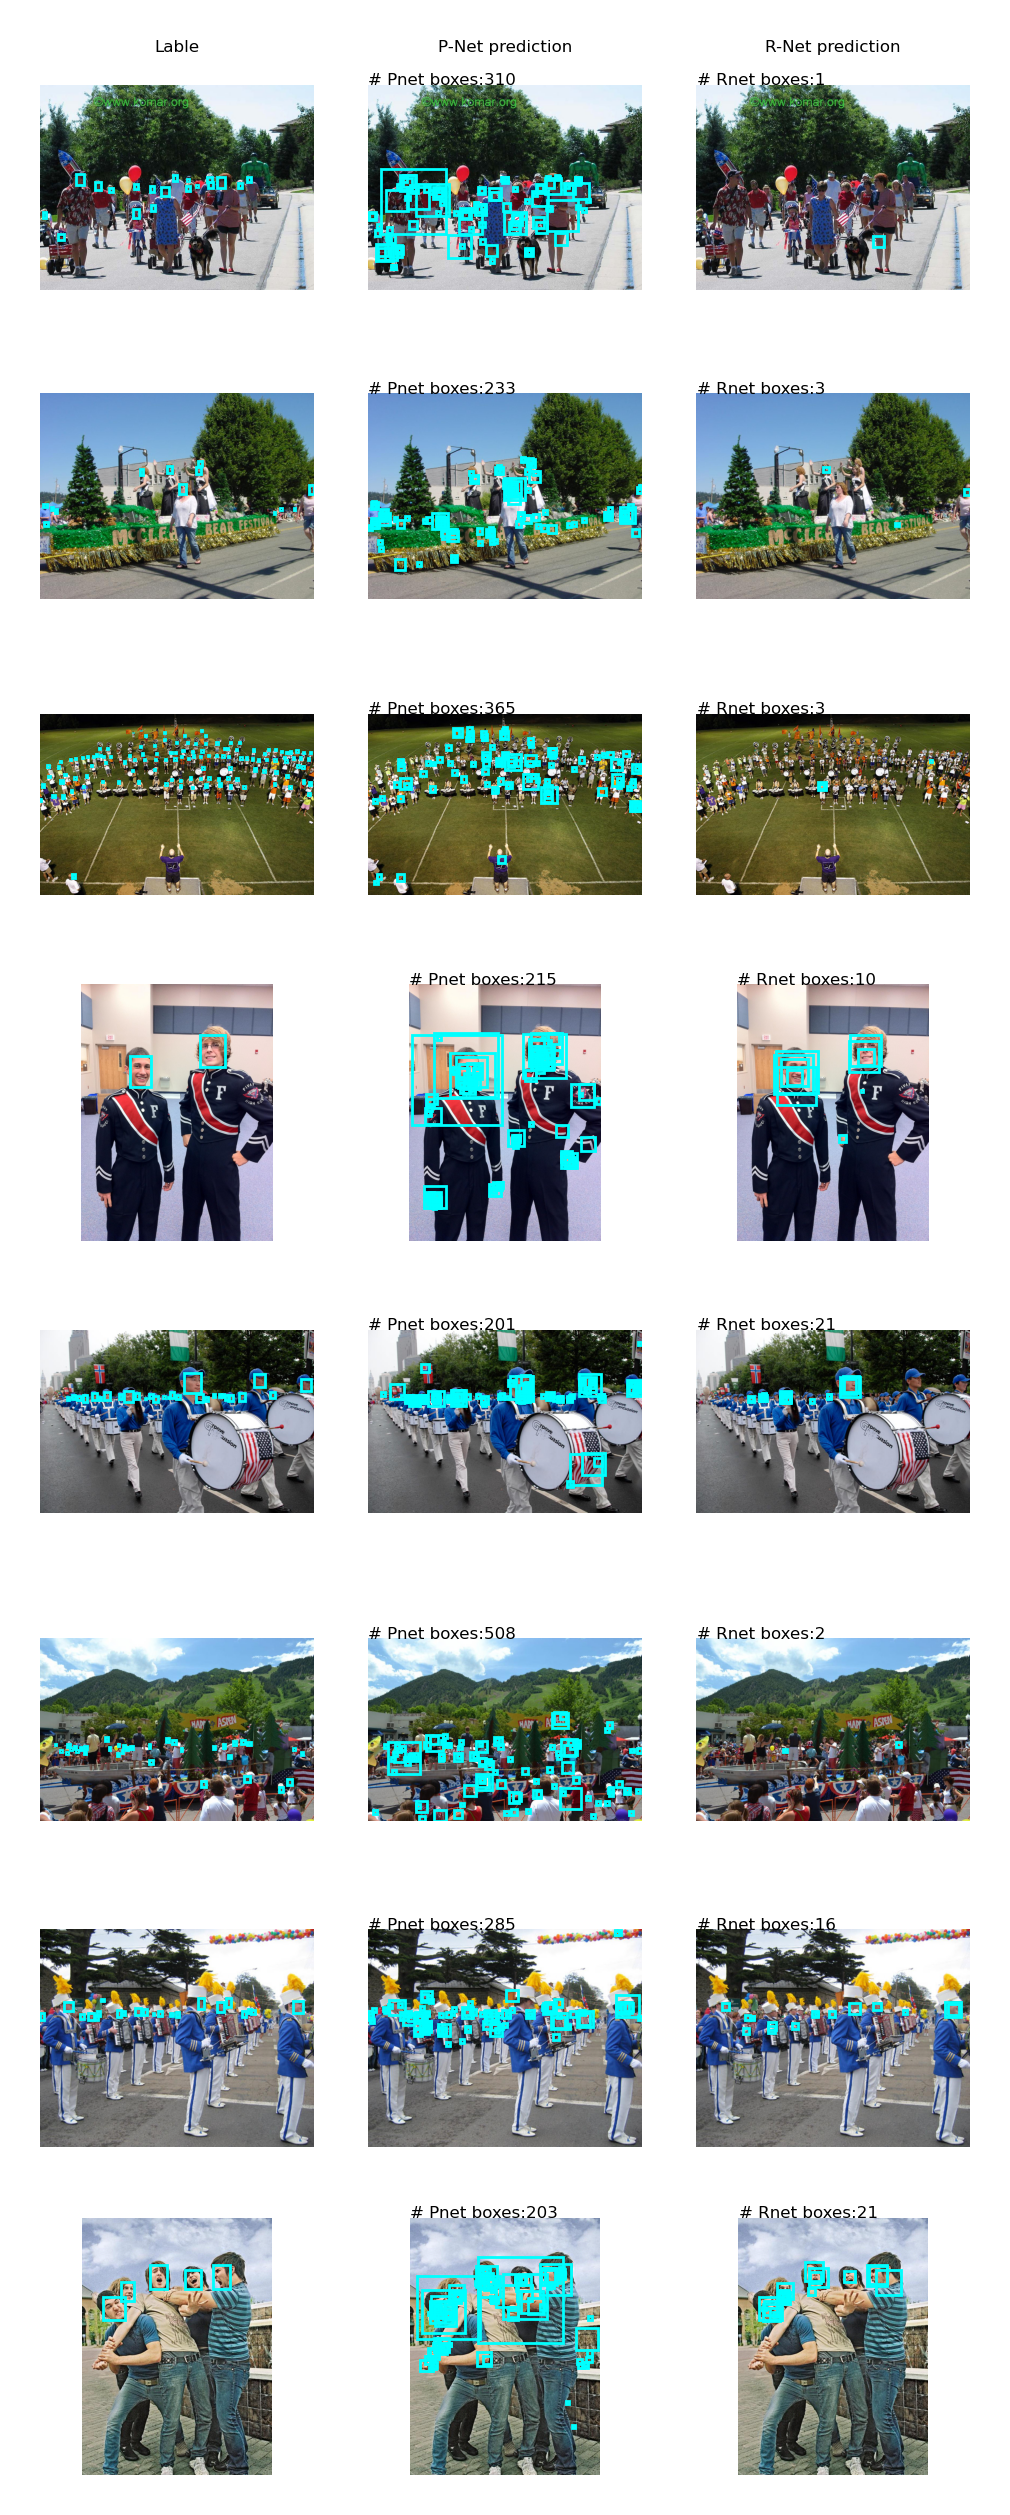

In [15]:
# get 8 fixed images
data_for_demo = create_pnet_data_txt_parser(eval_txt_path,eval_img_path ,num_data=40)
shuffle(data_for_demo)
data_for_demo=data_for_demo[:8]


# demo and plot
fig, ax = plt.subplots(8,3,dpi = 400, figsize=(3,8))

for i in range(len(data_for_demo)):
    img_pth, gts = data_for_demo[i]
    img = Image.open(img_pth)
    p_bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    r_bounding_boxes=rnet_boxes(img, rnet, p_bounding_boxes, show_boxes=False)
    ax[i,0].imshow(img)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3], fill=False, edgecolor = 'cyan',linewidth=0.5));
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# Pnet boxes:'+str(len(p_bounding_boxes)),fontsize=3)
    for b in p_bounding_boxes[:100]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
    
    ax[i,2].imshow(img)
    ax[i,2].text(0, 0, '# Rnet boxes:'+str(len(r_bounding_boxes)),fontsize=3)
    for b in r_bounding_boxes:
        ax[i,2].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   

for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Lable",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
ax[0][2].set_title("R-Net prediction",fontsize=3)
fig.show()
fig.savefig('demo_eval.png')

## Generate the Input Data for ONet  
- In this part, it puts the images into the PNet and RNet to get the prediction boxes and save the crop information and the name of the coresponding images in a txt file.

- The output txt file should have lines in this format:
      image_path * label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2 + ... + label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2 * \n
  Here is an example:
      ../input/wider-data/WIDER/WIDER_train/0--Parade/0_Parade_marchingband_1_462.jpg*n,668,226,681,246,888,348,967,427+n,668,226,681,246,437,455,504,522+p,668,226,681,246,434,435,556,557*\n
      
- If there is no prediction box, it will print:
         "Wrong: (None, None, None)"

In [16]:
train_img_faces = create_pnet_data_txt_parser(train_txt_path,train_img_path ,num_data=train_num)
eval_img_faces = create_pnet_data_txt_parser(eval_txt_path,eval_img_path ,num_data=eval_num)

In [17]:
def get_size_faces(img_faces, index):
    def load_img(img_path):
        try:
            img = Image.open(img_path)
            img = img.convert('RGB')
        except Exception:
            print('*** warning loading fail!')
            return
        return img

    img_face = img_faces[index]
    img_path = img_face[0]
    faces = np.array(img_face[1])      
    faces[:, 2] += faces[:, 0]
    faces[:, 3] += faces[:, 1]
   
    img=load_img(img_path)
    return img, faces

def get_crop_img_label_box(img ,faces,pnet,rnet):
    iou_th = {'n': (0, 0.3), 'pf': (0.4, 0.65), 'p': (0.65, 1.0)}
    bounding_boxes = pnet_boxes(img, pnet)
    bounding_boxes_rnet = rnet_boxes(img, rnet, bounding_boxes, show_boxes=False)
    if bounding_boxes_rnet is not None and len(bounding_boxes_rnet) != 0:
        bounding_boxes = np.vstack((bounding_boxes, bounding_boxes_rnet))
    if bounding_boxes is None:
        return None, None, None
    
    crop_box = None
    closet_face = None
    label_boxes=[]
    width,height=img.size
    
    for id, box in enumerate(bounding_boxes, start=1):
        box = [min(max(0, int(box[i])), width if i % 2 == 0 else height) for i in range(4)]
        if box[2] - box[0] < 48: continue
        iou = IoU(box, faces)
        iou_max = iou.max()
        iou_index = iou.argmax()
        closet_face = faces[iou_index]             
                
        for temp_label in iou_th:
            if iou_max < iou_th[temp_label][0] or iou_max > iou_th[temp_label][1]:
                continue
            else:
                label = temp_label
                crop_box = box
                closet_face=[str(l) for l in closet_face]
                crop_box=[str(l) for l in crop_box]
                label_boxes.append([label,closet_face,crop_box])

    return label_boxes

In [18]:
onet_train_data=open('onet_train_data.txt', 'w')
print('Train Begin')
for index in range(len(train_img_faces)):
    if index%500==0:
        print(index)
    img,faces=get_size_faces(train_img_faces, index)
    label_boxes=get_crop_img_label_box(img ,faces,pnet,rnet)
    img_path=train_img_faces[index][0]
    try:
        boxes='+'.join([w[0]+','+','.join(w[1])+','+','.join(w[2]) for w in label_boxes])
        onet_train_data.write(img_path+'*'+boxes+'* \n')
    except:
        print('Wrong:',label_boxes)
onet_train_data.close()   
print('Train End')

print('Eval Begin')
onet_eval_data=open('onet_eval_data.txt', 'w')
for index in range(len(eval_img_faces)):
    
    if index%500==0:
        print(index)
    img,faces=get_size_faces(eval_img_faces, index)
    label_boxes=get_crop_img_label_box(img ,faces,pnet,rnet)
    img_path=eval_img_faces[index][0]
    try:
        boxes='+'.join([w[0]+','+','.join(w[1])+','+','.join(w[2]) for w in label_boxes])
        onet_eval_data.write(img_path+'*'+boxes+'* \n')
    except:
        print('Wrong:',label_boxes)
onet_eval_data.close()


Train Begin
0
500
Wrong: (None, None, None)
1000
Wrong: (None, None, None)
Wrong: (None, None, None)
1500
Wrong: (None, None, None)
Wrong: (None, None, None)
Wrong: (None, None, None)
2000
Wrong: (None, None, None)
Wrong: (None, None, None)
Wrong: (None, None, None)
2500
Wrong: (None, None, None)
Wrong: (None, None, None)
3000
3500
4000
Wrong: (None, None, None)
4500
Wrong: (None, None, None)
Wrong: (None, None, None)
Wrong: (None, None, None)
5000
Wrong: (None, None, None)
Wrong: (None, None, None)
Wrong: (None, None, None)
5500
Wrong: (None, None, None)
Wrong: (None, None, None)
Wrong: (None, None, None)
Wrong: (None, None, None)
6000
Wrong: (None, None, None)
Wrong: (None, None, None)
Wrong: (None, None, None)
Wrong: (None, None, None)
6500
Wrong: (None, None, None)
7000
7500
Wrong: (None, None, None)
Wrong: (None, None, None)
Wrong: (None, None, None)
Wrong: (None, None, None)
Wrong: (None, None, None)
8000
Wrong: (None, None, None)
Wrong: (None, None, None)
Wrong: (None, None, Non